In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import pandas as pd
from numpy import linalg as LA
from scipy.constants import g
import math

4.1 Konsistenz der Flussaproximation

In [2]:
def reflektierender_block(h):
    h[0, :] = h[1, :]
    h[-1, :] = h[-2, :]
    h[:, 0] = h[:, 1]
    h[:, -1] = h[:, -2]
    return h

def erhaltungsschema_2D(h, hu, hv, CFL, Nx, Ny, darstellung):
    x = np.linspace(0, 10, Nx)
    y = np.linspace(0, 10, Ny)

    dx = x[1] - x[0]
    dy = y[1] - y[0]

    # Berechnung der Zeit
    z = 0
    tmax = 5

    # Matrizen Berechnen der F_j12a, F_j12b, F_j12c und  G_k12a, G_k12b, G_k12c

    F_j12a = np.zeros((Nx-1, Ny), dtype = np.double)
    F_j12b = np.zeros((Nx-1, Ny), dtype = np.double)
    F_j12c = np.zeros((Nx-1, Ny), dtype = np.double)
    G_k12a = np.zeros((Nx, Ny-1), dtype = np.double)
    G_k12b = np.zeros((Nx, Ny-1), dtype = np.double)
    G_k12c = np.zeros((Nx, Ny-1), dtype = np.double)
    Fa = np.zeros((Nx, Ny), dtype = np.double)
    Fb = np.zeros((Nx, Ny), dtype = np.double)
    Fc = np.zeros((Nx, Ny), dtype = np.double)
    Ga = np.zeros((Nx, Ny), dtype = np.double)
    Gb = np.zeros((Nx, Ny), dtype = np.double)
    Gc = np.zeros((Nx, Ny), dtype = np.double)
    #v1 = np.amax(h)
    #t1 = np.zeros(1)


    if darstellung == 3:
        fig = plt.figure(figsize=(10,10))
    if darstellung == 2:
        fig = plt.figure(figsize=(20,10))
        ax_contour = fig.add_subplot(111,frameon = False)
        plt.show(block= False)

    while z < tmax:
        # Berechnung der Eigenwerte
        EWX = np.array([hu[0,0]/h[0,0]-np.sqrt(g*h[0,0]), hu[0,0]/h[0,0]+np.sqrt(g*h[0,0])]) # Quelle: S.34 (3.5)
        EWY = np.array([hv[0,0]/h[0,0]-np.sqrt(g*h[0,0]), hv[0,0]/h[0,0]+np.sqrt(g*h[0,0])])
        for j in range(0,Nx):
            for k in range(0,Ny):
                EWX = np.append(EWX,[hu[j,k]/h[j,k]-np.sqrt(g*h[j,k]), hu[j,k]/h[j,k]+np.sqrt(g*h[j,k])])
                EWY = np.append(EWY,[hv[j,k]/h[j,k]-np.sqrt(g*h[j,k]), hv[j,k]/h[j,k]+np.sqrt(g*h[j,k])])
        dt = CFL * min(dx,dy)/(max(np.amax(EWX), np.amax(EWY))) # Quelle: S. 13 (1.58)
        z += dt

        # Fluss in der Mitte
        for j in range(0, Nx):
            for k in range(0, Ny):
                Fa[j,k] = hu[j,k] # Quelle: S.4 (1.1)
                Fb[j,k] = (hu[j,k]**2)/(h[j,k]) + 0.5*g*(h[j,k]**2)
                Fc[j,k] = (hu[j,k]*hv[j,k])/(h[j,k])
                Ga[j,k] = hv[j,k] # Quelle: S.4 (1.1)
                Gb[j,k] = (hu[j,k]*hv[j,k])/(h[j,k])
                Gc[j,k] = (hv[j,k]**2)/(h[j,k]) + 0.5*g*(h[j,k]**2)

        # Berechnung der F_j12a, F_j12b, F_j12c und  G_k12a, G_k12b, G_k12c
        for j in range(0, Nx-1):
            for k in range(0, Ny-1):
                F_j12a[j,k] = 0.25 * (dx/dt)*(h[j,k]  -   h[j+1,k]) + 0.5 * (Fa[j,k] + Fa[j+1,k]) # Quelle: S.15 (1.63)
                F_j12b[j,k] = 0.25 * (dx/dt)*(hu[j,k] - hu[j+1,k]) + 0.5 * (Fb[j,k] + Fb[j+1,k])
                F_j12c[j,k] = 0.25 * (dx/dt)*(hv[j,k] - hv[j+1,k]) + 0.5 * (Fc[j,k] + Fc[j+1,k])
                G_k12a[j,k] = 0.25 * (dy/dt)*(h[j,k]  -  h[j,k+1]) + 0.5 * (Ga[j,k] + Ga[j,k+1]) # Quelle: S.15 (1.64)
                G_k12b[j,k] = 0.25 * (dy/dt)*(hu[j,k] - hu[j,k+1]) + 0.5 * (Gb[j,k] + Gb[j,k+1])
                G_k12c[j,k] = 0.25 * (dy/dt)*(hv[j,k] - hv[j,k+1]) + 0.5 * (Gc[j,k] + Gc[j,k+1])

        # Berechnung der h, hu und hv
        for j in range(1, Nx-1):
            for k in range(1, Ny-1):
                h[j,k]  = h[j,k]  - (dt/dx) * (F_j12a[j,k] - F_j12a[j-1,k]) - ((dt/dy) * (G_k12a[j,k] - G_k12a[j,k-1])) # Quelle: HA 3 (3.33)
                hu[j,k] = hu[j,k] - (dt/dx) * (F_j12b[j,k] - F_j12b[j-1,k]) - ((dt/dy) * (G_k12b[j,k] - G_k12b[j,k-1])) # + dt * S(U) für 3.3
                hv[j,k] = hv[j,k] - (dt/dx) * (F_j12c[j,k] - F_j12c[j-1,k]) - ((dt/dy) * (G_k12c[j,k] - G_k12c[j,k-1]))

        #Reflektierende Randbedingungen
        h = reflektierender_block(h)
        hu = reflektierender_block(hu)
        hv = reflektierender_block(hv)
        u = hu/h
        v = hv/h
        #v1 = np.append(v1, [np.amax(h)])
        #t1 = np.append(t1, [z])

        # #create a meshgrid
        X,Y = np.meshgrid(x,y)

        if darstellung == 3:
            #plot the surface in 3D
            ax = fig.gca(projection='3d')
            ax.plot_surface(X, Y, h, cmap='cool', linewidth=0, antialiased=False)
            ax.set_title('Lax-Friedrich')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('h')
            ax.set_xlim(0,10)
            ax.set_ylim(0,10)
            ax.set_zlim(1.4,2.1)

            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.pause(0.01)
            plt.clf()

        if darstellung == 2:
            ax_contour.cla()
            ax_contour.set_title('Höhenverlauf')
            contour = ax_contour.contourf(X, Y, h, shading='auto', vmax=2, vmin=1.5, cmap='jet')
            cb = fig.colorbar(contour, ax=ax_contour)
            # ax_cotour.pcolormesh(X, Y, h, shading='auto', vmax=2, vmin=1.5, cmap ='jet')

            ax_contour.quiver(X, Y, v, u)
            ax_contour.set_aspect('equal')

            plt.draw()
            plt.pause(0.01)
            cb.remove()


    return h, hu, hv

4.2 Konvergenzbestimmung

In [66]:
def Anfangsbedigungen(Nx,CFL,verfahren):
    xmax = 10
    xmin = 0
    
    x = np.linspace(xmin, xmax, Nx)
    dx = x[1]-x[0]
    dt = CFL*dx                     # Zeitschrittweite
    t_ende = 5                      # Endzeit
    Nt = int(t_ende/dt)             # Anzahl der Zeitschritte

    #Upwind-Verfahren
    c_positiv = 1*(dt/dx)
    c_negativ = 0

    #Lax-Friedrich / Lax-Wendroff-Verfahren
    c=dt/dx

    # Glatte Anfangsbedingung
    Uo_glatt = np.exp(-2.5*(x-2)**2)

    # Initialisierung der Zustandsmatrix
    U_glatt = np.zeros((Nt+1, Nx))
    U_glatt[0] = Uo_glatt

    # Unstetige Anfangsbedingung
    Uo_unstetig = np.where(np.logical_and(x>=1, x<=3), 1, 0)

    # Initialisierung der Zustandsmatrix
    U_unstetig = np.zeros((Nt+1, Nx))
    U_unstetig[0] = Uo_unstetig

    if verfahren == 'UpWind':
        return U_glatt, U_unstetig, c_positiv, c_negativ, Nt,  Nx #Upwind-Verfahren
    elif verfahren == "Lax-Wendroff": 
        return U_glatt, U_unstetig, c, Nt, Nx #Lax-Wendroff-Verfahren 
    elif verfahren  == "Analytisch":
        return U_glatt, U_unstetig, Nt, Nx, x #Analytische Lösung
    


#Analytische Lösung
def analytisch(CFL,Nx): 
    
    U_glatt, U_unstetig, Nt, Nx, x = Anfangsbedigungen(Nx,CFL,verfahren = 'Analytisch')
    t = np.linspace(0, 5, Nt)
    
    #Lösung des beschriebenen Problems
    for n in range(Nt):
        for i in range(0, Nx-1):
            U_glatt[n+1, i+1] = np.exp(-2.5*(x[i]-t[n]-2)**2)
            U_unstetig[n+1, i+1] = np.logical_and(x[i]-t[n]>=1, x[i]-t[n]<=3)
        #Randbedingungen
        U_glatt[n+1, 0] = 0
        U_glatt[n+1, -1] = 0
        U_unstetig[n+1, 0] = 0
        U_unstetig[n+1, -1] = 0
        
    return U_glatt, U_unstetig

def upwind_verfahren(CFL,Nx):

    U_glatt, U_unstetig, c_positiv, c_negativ,Nt, Nx = Anfangsbedigungen(Nx,CFL,verfahren = 'UpWind')
    
    #Lösung des beschriebenen Problems
    for n in range(Nt):
        for i in range(1, Nx-1):
            U_glatt[n+1, i] = U_glatt[n, i] - c_positiv*(U_glatt[n, i] - U_glatt[n, i-1]) + c_negativ*(U_glatt[n, i+1] - U_glatt[n, i])
            U_unstetig[n+1, i] = U_unstetig[n, i] - c_positiv*(U_unstetig[n, i] - U_unstetig[n, i-1]) + c_negativ*(U_unstetig[n, i+1] - U_unstetig[n, i])
            
        #Randbedingungen
        U_glatt[n+1, 0] = 0
        U_glatt[n+1, Nx-1] = 0
        U_unstetig[n+1, 0] = 0
        U_unstetig[n+1, Nx-1] = 0
        
    return U_glatt, U_unstetig

def lax_wendroff(CFL,Nx):
    U_glatt, U_unstetig, c, Nt, Nx = Anfangsbedigungen(Nx,CFL,verfahren = 'Lax-Wendroff')
    #Lösung des beschriebenen Problems
    for n in range(Nt):
        for i in range(1, Nx-1):
            U_glatt[n+1, i] = U_glatt[n, i] - 0.5*c*(U_glatt[n, i+1] - U_glatt[n, i-1]) + 0.5*c**2*(U_glatt[n, i+1] - 2*U_glatt[n, i] + U_glatt[n, i-1])
            U_unstetig[n+1, i] = U_unstetig[n, i] - 0.5*c*(U_unstetig[n, i+1] - U_unstetig[n, i-1]) + 0.5*c**2*(U_unstetig[n, i+1] - 2*U_unstetig[n, i] + U_unstetig[n, i-1])
        #Randbedingungen
        U_glatt[n+1, 0] = 0
        U_glatt[n+1, Nx-1] = 0
        U_unstetig[n+1, 0] = 0
        U_unstetig[n+1, Nx-1] = 0
    
    return U_glatt, U_unstetig



In [143]:
def konvergenz(CFL, k, norm,verfahren):

        
    U_ana_glatt_k, U_ana_unstetig_k = analytisch(CFL, Nx = 2**(k))
    U_ana_glatt_k1, U_ana_unstetig_k1= analytisch(CFL, Nx = 2**(k+1))
    
    if verfahren == "UpWind":
        U_ver_glatt_k, U_ver_unstetig_k= upwind_verfahren(CFL, Nx = 2**(k))
        U_ver_glatt_k1, U_ver_unstetig_k1= upwind_verfahren(CFL,Nx = 2**(k+1))
        
    elif verfahren == "Lax-Wendroff":
        U_ver_glatt_k, U_ver_unstetig_k= lax_wendroff(CFL, Nx = 2**(k))
        U_ver_glatt_k1, U_ver_unstetig_k1= lax_wendroff(CFL, Nx = 2**(k+1))
        
    # print(U_ana_glatt_k.shape)
    # print(U_ver_glatt_k.shape)
        
    x_k = np.linspace(0, 10, 2**(k))
    dx_k = x_k[1]-x_k[0]
    
    x_k1 = np.linspace(0, 10, 2**(k+1))
    dx_k1 = x_k1[1]-x_k1[0]

    #Experimentelle Konvergenzbestimmung / Quelle: HA4, Gl. 4.37
    EOC_glatt = np.math.log(LA.norm((U_ana_glatt_k1 - U_ver_glatt_k1), norm)) - np.log(LA.norm((U_ana_glatt_k - U_ver_glatt_k),norm)) 
    EOC_unstetig = (np.math.log(LA.norm((U_ana_unstetig_k1 - U_ver_unstetig_k1), norm)) - np.log(LA.norm((U_ana_unstetig_k - U_ver_unstetig_k),norm)))/(np.math.log(dx_k1)-np.math.log(dx_k))
        
    return EOC_glatt, EOC_unstetig

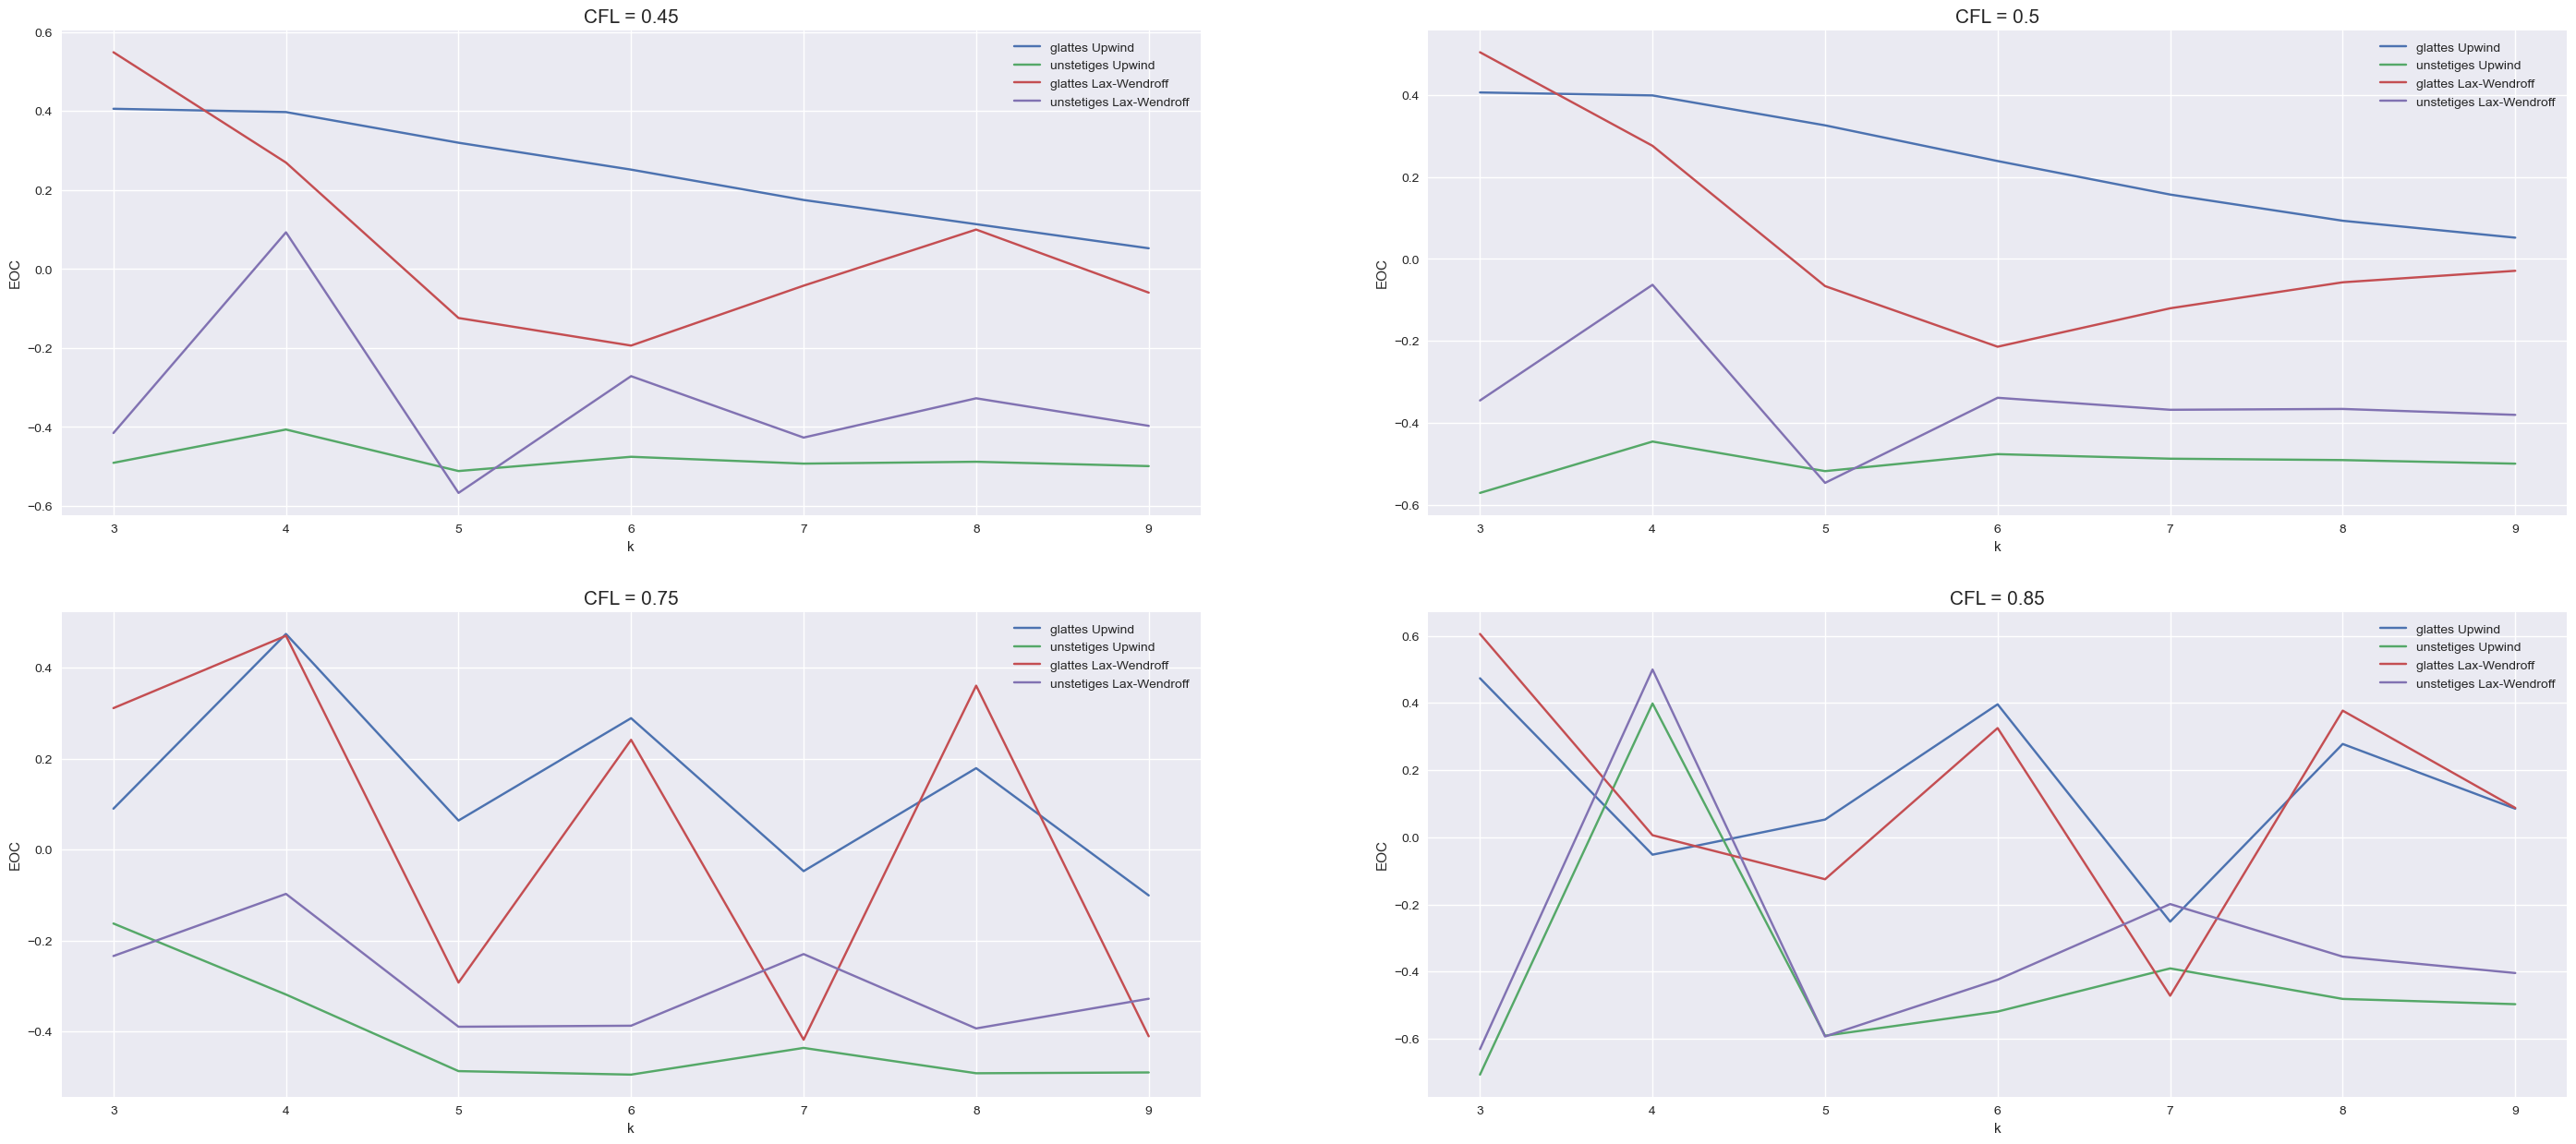

In [178]:
plt.style.use('seaborn')

x = np.array([3,4,5,6,7,8,9])
ks = np.array([3,4,5,6,7,8,9])

norm=np.inf

CFLs = [0.45, 0.5, 0.75, 0.85]
# CFLs = [0.45]

fig = plt.figure(figsize=(35, 15))
# fig.suptitle(f'Glatte vs Unstetige Anfangsbedingungen mit Norm = {norm}', fontsize=16)


i=1

for CFL in CFLs:
    eoc_glatt_upwind = []
    eoc_unstetig_upwind = []

    eoc_glatt_lax = []
    eoc_unstetig_lax = []
    
    for k in ks:
        # Upwind Verfahren
        EOC_glatt_upwind, EOC_unstetig_upwind = konvergenz(CFL = CFL, k = k, norm = norm, verfahren = "UpWind")
        eoc_glatt_upwind.append(EOC_glatt_upwind)
        eoc_unstetig_upwind.append(EOC_unstetig_upwind)
        
        # Lax-Wendroff Verfahren
        EOC_glatt_lax, EOC_unstetig_lax = konvergenz(CFL = CFL, k = k, norm = norm, verfahren = "Lax-Wendroff")
        eoc_glatt_lax.append(EOC_glatt_lax)
        eoc_unstetig_lax.append(EOC_unstetig_lax)
        
    
    #Subplots
    ax = fig.add_subplot(2,2,i)
    ax.plot(x, eoc_glatt_upwind, label='glattes Upwind')
    ax.plot(x, eoc_unstetig_upwind, label='unstetiges Upwind')
    ax.plot(x, eoc_glatt_lax, label='glattes Lax-Wendroff')
    ax.plot(x, eoc_unstetig_lax, label='unstetiges Lax-Wendroff')
    ax.title.set_text(f'CFL = {CFL}')
    ax.title.set_fontsize(15)
    ax.set_xlabel('k')
    ax.set_ylabel('EOC')
    plt.legend()
    i+=1
    
plt.show()
   
    